In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 4.9MB/s 
     |████████████████████████████████| 1.0MB 22.7MB/s 
     |████████████████████████████████| 890kB 28kB/s 
     |████████████████████████████████| 3.8MB 12.3MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/136-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [7]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_3.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_4.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_5.tar.gz'

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,6c3221ae9b,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,115,3,21,1,train,validation,train,train,train
1,6d059e310b,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,100,7,14,1,train,train,train,validation,train
2,ce7f8a5210,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,114,7,19,1,validation,train,train,train,train
3,456c4304cd,first weekend at home,first weekend at home,neutral,1.000000,21,21,4,4,train,validation,train,train,train
4,6b78e2821a,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,102,31,20,5,train,train,train,train,validation


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train.npy
fold_1/x_train_aux2.npy
fold_1/x_train.npy
fold_1/y_train_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/y_valid_mask.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train.npy
fold_2/x_train_aux2.npy
fold_2/x_train.npy
fold_2/y_train_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/y_valid_mask.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train.npy
fold_3/x_train_aux2.npy
fold_3/x_train.npy
fold_3/y_train_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/y_valid_mask.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_4/
fold_4/y_valid.npy
fold_4/x_valid_aux.npy
fold_4/y_train.npy
fold_4/x_train_aux2.npy
fold_4/x_train.npy
fold_4/y_train_aux.npy
fold_4/y_train_mask.npy
fold_4/x_train_aux.npy
fo

# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


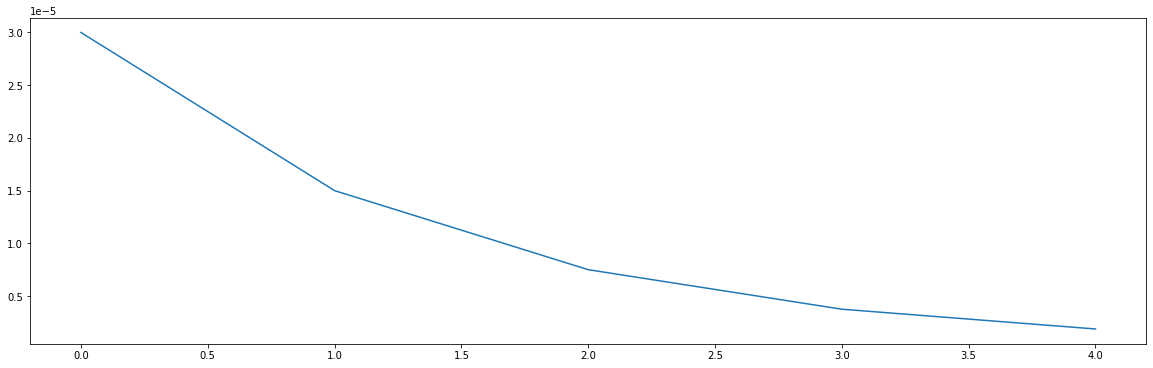

In [11]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [13]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.SGD(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size), 
                               momentum=0.9, nesterov=True)
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    model.load_weights(MODEL_BASE_PATH + model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 583 steps, validate for 145 steps
Instructions for updating:
renamed to `run`

EPOCH 1/5
time: 229.0s loss: 4.8970 loss_start: 2.4531 loss_end: 2.4438 val_loss: 2.2489 val_loss_start: 1.1663 val_loss_end: 1.0826
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/136-roBERTa_base/model_fold_1.h5"

EPOCH 2/5
time: 219.8s loss: 4.2622 loss_start: 2.1673 loss_end: 2.0949 val_loss: 2.1543 val_loss_start: 1.1349 val_loss_end: 1.0193
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/136-roBERTa_base/model_fold_1.h5"

EPOCH 3/5
time: 222.1s loss: 4.1640 loss_start: 2.1155 loss_end: 2.0485 val_loss: 2.0976 val_loss_start: 1.0781 val_loss_end: 1.0195
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/136-roBERTa_base/model_fold_1.h5"

EPOCH 4/5
time: 223.2s loss: 4.1195 loss_start: 2.0936 loss_end: 2.0259 val_loss: 2.13

# Model loss graph

Fold: 1


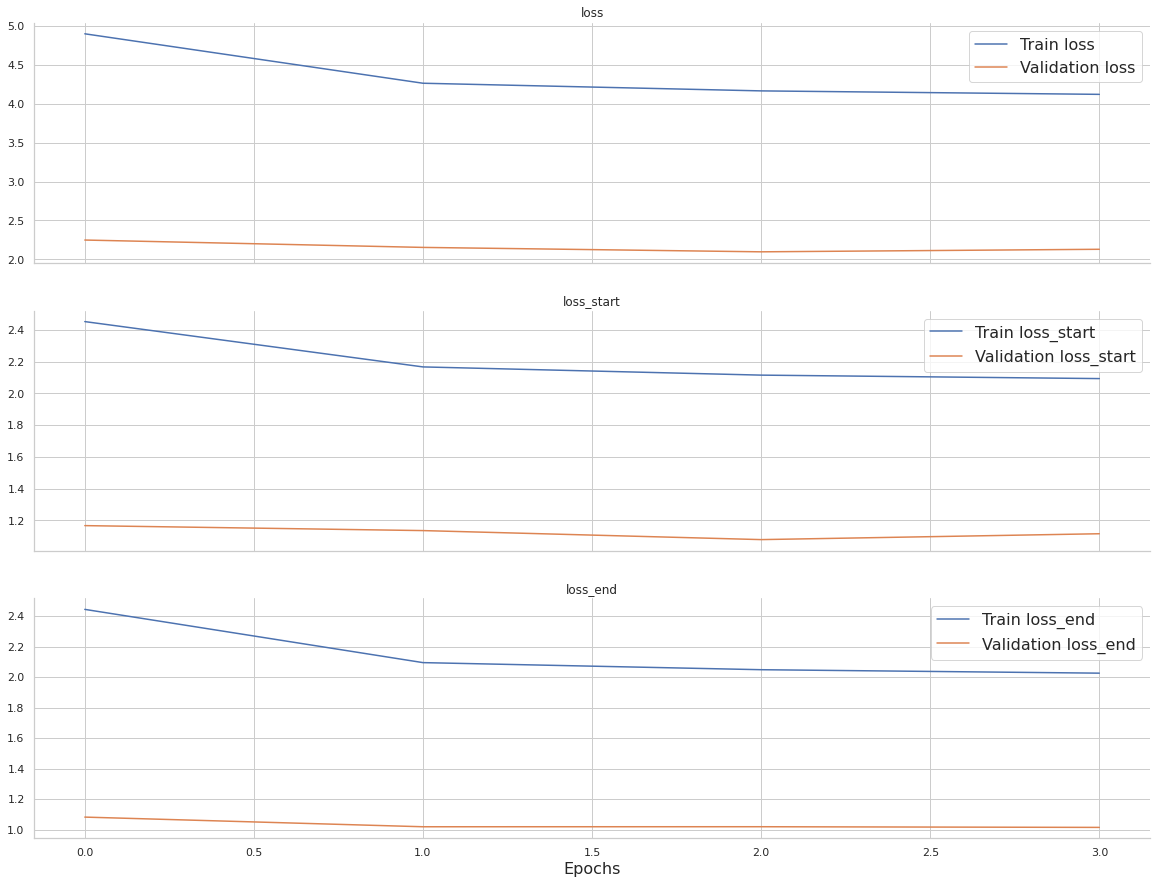

Fold: 2


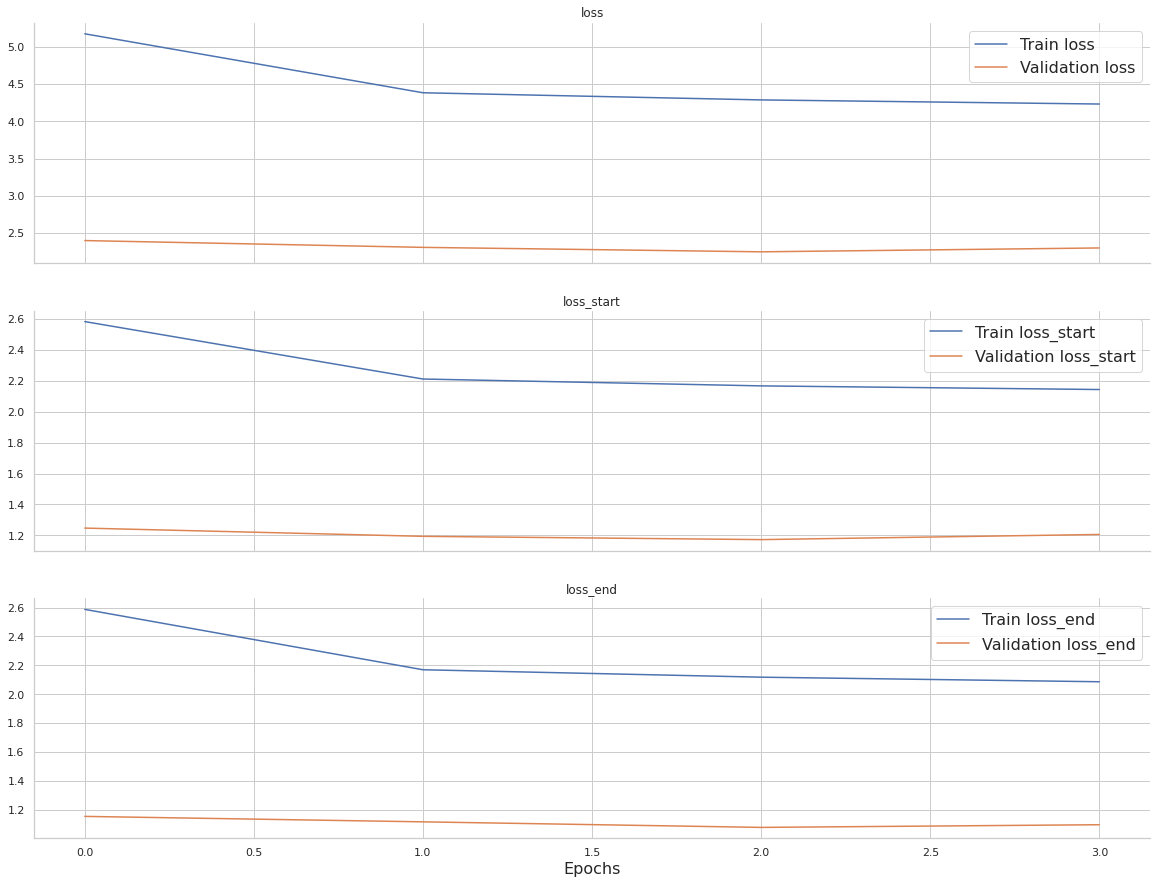

Fold: 3


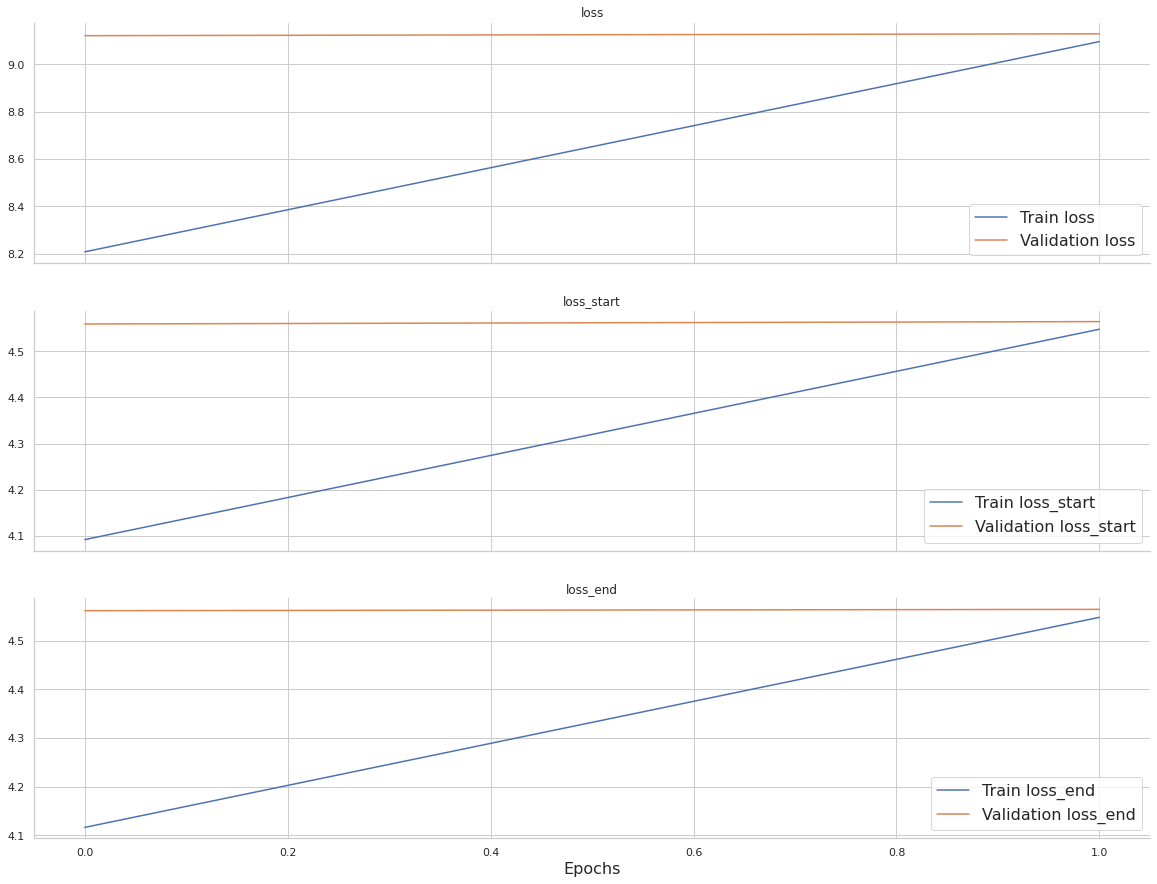

Fold: 4


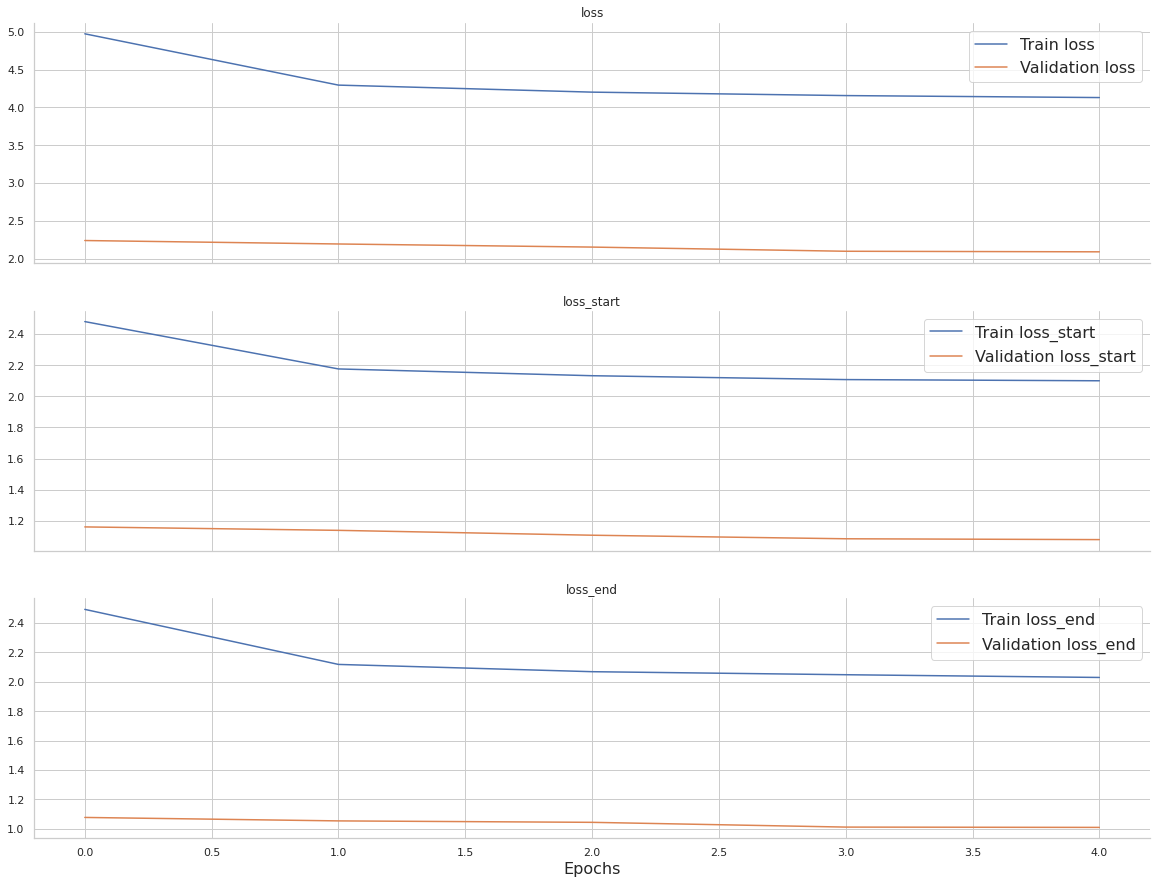

Fold: 5


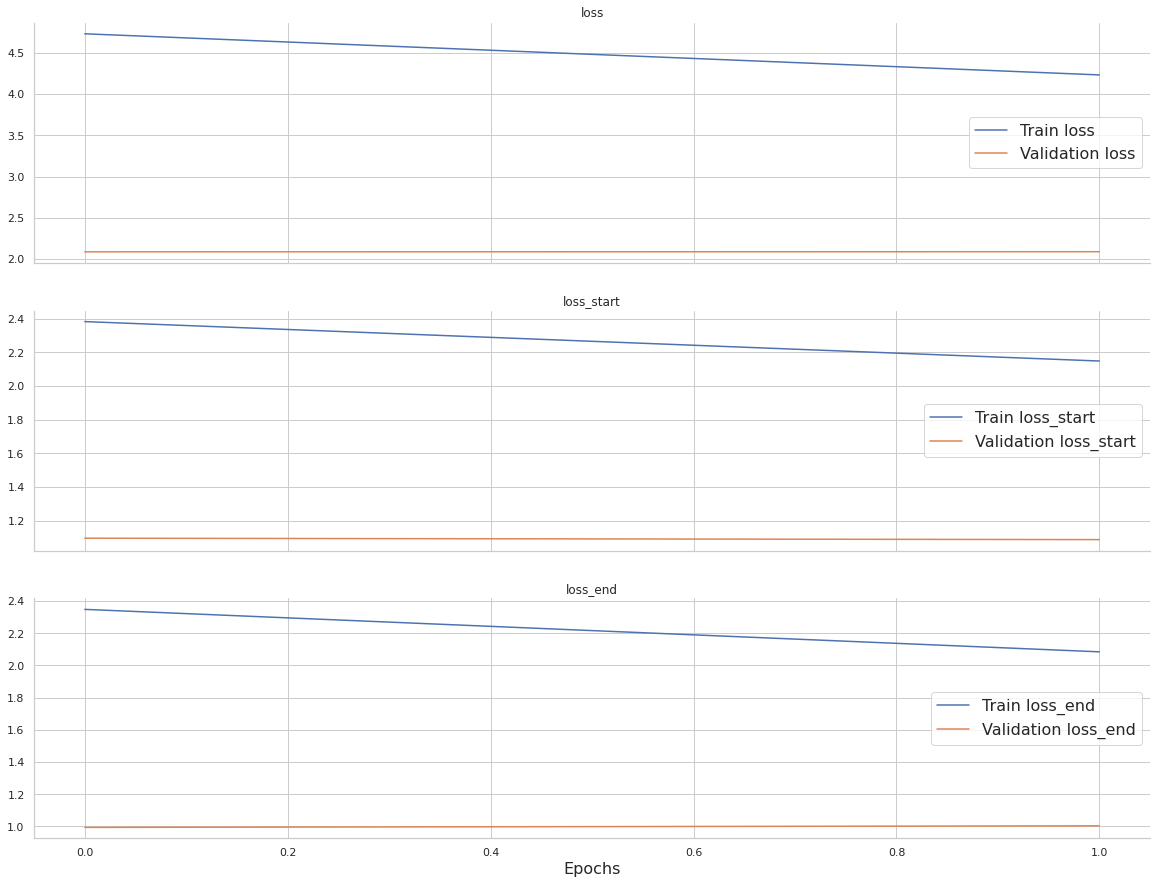

In [14]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [15]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.543266,0.527700,0.015566,0.684791,0.666048,0.669905,0.642624,0.012535,0.012638,0.685760,0.660418,0.663341,0.656773
Sentiment negative,0.424050,0.402155,0.021895,0.539600,0.530871,0.516472,0.469243,0.011083,0.013873,0.542833,0.506574,0.510259,0.490212
Sentiment neutral,0.781837,0.780994,0.000843,0.974177,0.972648,0.973071,0.974647,0.013619,0.014139,0.974214,0.972952,0.974105,0.970584
Sentiment positive,0.423941,0.399989,0.023952,0.540620,0.494711,0.520197,0.484084,0.012903,0.009903,0.540278,0.501727,0.505709,0.509522
0 <= text wordCnt < 3,0.684736,0.686191,-0.001455,0.854212,0.842014,0.845004,0.833333,0.038194,0.035433,0.843446,0.875731,0.842825,0.844444
3 <= text wordCnt < 10,0.597545,0.586218,0.011326,0.747420,0.738686,0.737402,0.720086,0.015705,0.015661,0.752327,0.726605,0.734870,0.730053
10 <= text wordCnt < 30,0.510357,0.492173,0.018184,0.646645,0.622629,0.628576,0.597508,0.010017,0.010129,0.645898,0.618242,0.620648,0.612355
30 <= text wordCnt < 100,0.446044,0.442416,0.003628,0.573495,0.530103,0.567296,0.526577,0.005718,0.003253,0.582171,0.596417,0.501539,0.555728
0 <= selected text wordCnt < 3,0.501696,0.475495,0.026200,0.648679,0.600512,0.598840,0.559734,0.010267,0.011558,0.629771,0.590630,0.620921,0.615043


# Visualize predictions

In [16]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,fml,1.000000,so instead of laying out in this 90 degrees i`...,0.052632,l,0.00,miso/rice/sushi/mochi in an hour fml,0.200000,miso/rice/sushi/mochi in an hour fml,0.200000
1,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,hitting the (fairly empty),0.250000,hitting the (fairly empty),0.250000,in,0.00,airly empty),0.000000,hitting the (fairly empty),0.250000
2,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,welcome,1.000000,welcome,1.000000,anyway,0.00,welcome,1.000000,welcome,1.000000
3,first weekend at home,first weekend at home,neutral,1.000000,first weekend at home,1.000000,first weekend at home,1.000000,at,0.25,first weekend at home,1.000000,first weekend at home,1.000000
4,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,impatiently,0.200000,would like june the nineteenth to hurry it sel...,0.312500,car,0.00,impatiently,0.200000,would like june the nineteenth to hurry it sel...,0.312500
5,you realize you just did a solid. better than...,you realize you just did a solid. better than...,positive,1.000000,better,0.083333,better,0.083333,,0.00,better,0.083333,better,0.083333
6,still a bit of a warning signal in my head say...,still a bit of a warning signal in my head,negative,0.428571,warning,0.111111,headache,0.000000,quick,0.00,warning signal,0.222222,warning signal in my head saying: 'you want ye...,0.285714
7,im finally going home but didnt get to finish ...,im finally going home but didnt get to finish ...,neutral,1.000000,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000,,0.00,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000
8,is actually feeling awake today,is actually feeling awake today,neutral,1.000000,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000,,0.00,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000
9,sorry friends - i`m swamped with deadlines ri...,sorry friends,negative,0.100000,sorry,0.500000,sorry,0.500000,,0.00,sorry,0.500000,sorry,0.500000
